In [1]:
import os
import torch
import torch.nn as nn
import numpy as np
import torch.nn.functional as F

import pandas as pd
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms, utils
from torchsummary import summary
from PIL import Image
from bokeh.plotting import figure
from bokeh.io import show
from bokeh.models import LinearAxis, Range1d

In [2]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

In [3]:
"""Basic Dataset class which loads images from a folder

Returns:
    [type]: [description]
"""

class ImageDataset(Dataset):
    """Project Image dataset"""

    def __init__(self, csv_file, root_dir, transform):
        self.annotations = pd.read_csv(csv_file)
        self.root_dir = root_dir
        self.transform = transform

    def __len__(self):
        return len(self.annotations)
    
    def __getitem__(self, index):
        img_path = os.path.join(self.root_dir, self.annotations.iloc[index, 0])
        image = Image.open(img_path).convert('RGB')
        #image = Image.fromarray(image)
        y_label = torch.tensor(int(self.annotations.iloc[index, 2]))

        if self.transform:
            image = self.transform(image)

        return (image, y_label)

In [4]:
class Net(nn.Module):

    def __init__(self, num_classes=6):
        super(Net, self).__init__()
        self.num_classes = num_classes
        self.conv1 = nn.Conv2d(3, 64, 5)
        self.pool1 = nn.MaxPool2d(2, 2)
        self.conv2 = nn.Conv2d(64, 128, 5)
        self.conv3 = nn.Conv2d(128, 64, 5)
        self.pool2 = nn.MaxPool2d(2, 2)
        self.conv4 = nn.Conv2d(64, 64, 5)
        self.pool3 = nn.MaxPool2d(2, 2)

        self.fc1 = nn.Linear(64*23*23, self.num_classes)

    def forward(self, x):
        x = self.conv1(x)
        x = F.relu(x)
        x = self.pool1(x)

        x = self.conv2(x)
        x = F.relu(x)

        x = self.conv3(x)
        x = F.relu(x)
        x = self.pool2(x)

        x = self.conv4(x)
        x = F.relu(x)
        x = self.pool3(x)
        #print(x.shape)
        x = x.view(-1, 64 * 23 *23)
        x = self.fc1(x)

        return x

# class Net(nn.Module):
#     def __init__(self):
#         super(Net, self).__init__()
#         self.layer1 = nn.Sequential(
#             nn.Conv2d(3, 32, kernel_size=5, stride=1, padding=2),
#             nn.ReLU(),
#             nn.MaxPool2d(kernel_size=2, stride=2))
#         self.layer2 = nn.Sequential(
#             nn.Conv2d(32, 64, kernel_size=5, stride=1, padding=2),
#             nn.ReLU(),
#             nn.MaxPool2d(kernel_size=2, stride=2))
#         self.drop_out = nn.Dropout()
#         self.fc1 = nn.Linear(200704, 1000)
#         self.fc2 = nn.Linear(1000, 6)

#     def forward(self, x):
#         out = self.layer1(x)
#         out = self.layer2(out)
#         out = out.reshape(out.size(0), -1)
#         out = self.drop_out(out)
#         #print(out.shape)
#         out = self.fc1(out)
#         out = self.fc2(out)
#         return out

In [5]:
model = Net().to(device)
#print(model)
summary(model, (3, 224, 224))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 64, 220, 220]           4,864
         MaxPool2d-2         [-1, 64, 110, 110]               0
            Conv2d-3        [-1, 128, 106, 106]         204,928
            Conv2d-4         [-1, 64, 102, 102]         204,864
         MaxPool2d-5           [-1, 64, 51, 51]               0
            Conv2d-6           [-1, 64, 47, 47]         102,464
         MaxPool2d-7           [-1, 64, 23, 23]               0
            Linear-8                    [-1, 6]         203,142
Total params: 720,262
Trainable params: 720,262
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.57
Forward/backward pass size (MB): 48.20
Params size (MB): 2.75
Estimated Total Size (MB): 51.52
----------------------------------------------------------------


In [6]:
# Define Data paths
train_path = '../dataset/set_dataset/train'
train_labels = '../dataset/set_dataset/train_labes.csv'
val_path = '../dataset/set_dataset/val'
val_labels = '../dataset/set_dataset/val_labes.csv'
test_path = '../dataset/set_dataset/test'
test_labels = '../dataset/set_dataset/test_labes.csv'

In [7]:
mean_val = [0.5, 0.5, 0.5]
std_val = [0.5, 0.5, 0.5]

In [8]:
train_transforms = transforms.Compose([
    transforms.Resize([224, 224]),
    transforms.RandomHorizontalFlip(p=0.5),
    transforms.RandomCrop(224),
    transforms.ToTensor(),
    transforms.Normalize(mean_val, std_val),
])

test_val_transforms = transforms.Compose([
    transforms.Resize([224, 224]),
    transforms.CenterCrop(224),
    transforms.ToTensor(),
    transforms.Normalize(mean_val, std_val),
])

In [9]:
train_data = ImageDataset(train_labels, train_path, train_transforms)
val_data = ImageDataset(val_labels, val_path, test_val_transforms)
test_data = ImageDataset(test_labels, test_path, test_val_transforms)

In [10]:
train_loader = DataLoader(train_data, batch_size=6, shuffle=True, num_workers=4)
valloader = DataLoader(val_data, batch_size=6, shuffle=True, num_workers=4)
test_loader = DataLoader(test_data, batch_size=6, shuffle=True, num_workers=4)

classes = ('bolt', 'flange', 'lead_block', 'nut', 'pipe')

In [11]:
train_size = len(train_data)
val_size = len(val_data)
test_size = len(test_data)

print(f"Train data size: {train_size}\nValidation data size: {val_size}\n\
Test data size: {test_size}\nTotal data size: {train_size + val_size + test_size}")

Train data size: 1519
Validation data size: 474
Test data size: 379
Total data size: 2372


In [12]:
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(model.parameters(), lr=0.001, momentum=0.9)

In [13]:
num_epochs = 2
total_step = len(train_loader)
loss_list = []
acc_list = []


for epoch in range(num_epochs):
    print(epoch)
    print('-'*10)
    running_loss = 0.0
    for i, (images, labels) in enumerate(train_loader):
        images, labels = images.to(device), labels.to(device)
        outputs = model(images)
        loss = criterion(outputs, labels)
        loss_list.append(loss.item())
        
        # Back propagation
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
        # Accuracy
        total = labels.size(0)
        _, predicted = torch.max(outputs.data, 1)
        correct = (predicted == labels).sum().item()
        acc_list.append(correct / total)
        
        if (i + 1) % 50 == 0:
            print('Epoch [{}/{}], Step [{}/{}], Loss: {:.4f}, Accuracy: {:.2f}%'
                  .format(epoch + 1, num_epochs, i + 1, total_step, loss.item(),
                          (correct / total) * 100))

0
----------
Epoch [1/2], Step [50/254], Loss: 1.3859, Accuracy: 50.00%
Epoch [1/2], Step [100/254], Loss: 1.5176, Accuracy: 33.33%
Epoch [1/2], Step [150/254], Loss: 1.6670, Accuracy: 16.67%
Epoch [1/2], Step [200/254], Loss: 1.3392, Accuracy: 33.33%
Epoch [1/2], Step [250/254], Loss: 1.6054, Accuracy: 16.67%
1
----------
Epoch [2/2], Step [50/254], Loss: 1.5434, Accuracy: 16.67%
Epoch [2/2], Step [100/254], Loss: 1.2826, Accuracy: 50.00%
Epoch [2/2], Step [150/254], Loss: 1.2428, Accuracy: 33.33%
Epoch [2/2], Step [200/254], Loss: 1.7184, Accuracy: 16.67%
Epoch [2/2], Step [250/254], Loss: 1.5190, Accuracy: 16.67%


In [14]:
# Test the model
model.eval()
with torch.no_grad():
    correct = 0
    total = 0
    for images, labels in test_loader:
        images, labels = images.to(device), labels.to(device)
        outputs = model(images)
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

    print('Test Accuracy of the model on the 10000 test images: {} %'.format((correct / total) * 100))

Test Accuracy of the model on the 10000 test images: 43.53562005277045 %


In [15]:
MODEL_STORE_PATH = './'

# Save the model and plot
torch.save(model.state_dict(), MODEL_STORE_PATH + 'conv_net_model.ckpt')

In [16]:
p = figure(y_axis_label='Loss', width=850, y_range=(0, 1), title='PyTorch ConvNet results')
p.extra_y_ranges = {'Accuracy': Range1d(start=0, end=100)}
p.add_layout(LinearAxis(y_range_name='Accuracy', axis_label='Accuracy (%)'), 'right')
p.line(np.arange(len(loss_list)), loss_list)
p.line(np.arange(len(loss_list)), np.array(acc_list) * 100, y_range_name='Accuracy', color='red')
show(p)

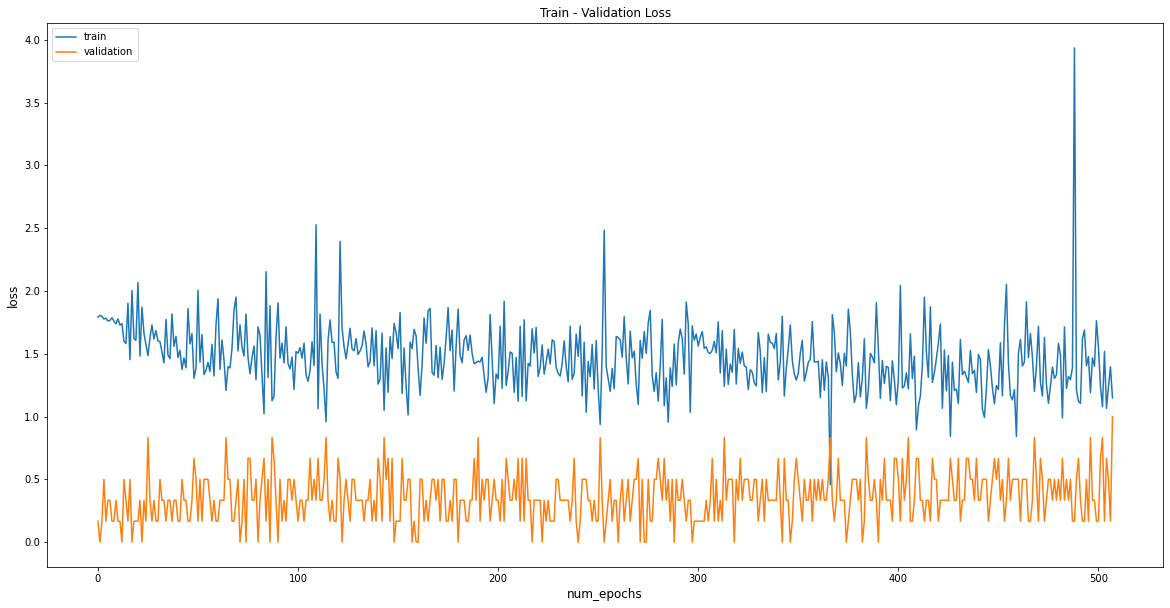

In [17]:
import matplotlib.pyplot as plt

fig = plt.figure(figsize=(20,10))
plt.title("Train - Validation Loss")
plt.plot( loss_list, label='train')
plt.plot( acc_list, label='validation')
plt.xlabel('num_epochs', fontsize=12)
plt.ylabel('loss', fontsize=12)
plt.legend(loc='best')